# **LIBRARIES**

In [1]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [2]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **DATASET**




In [4]:
def genAugmLayer(seed): 
    return tf.keras.Sequential([
     tfkl.RandomFlip("horizontal"),
     tfkl.RandomRotation(0.5),
     tfkl.RandomZoom( height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3),fill_mode = 'reflect',seed=seed), 
     tfkl.RandomTranslation( height_factor=(-0.3, 0.3),width_factor=(-0.3, 0.3),seed=13)])

In [6]:
imbalClasses = tf.keras.utils.image_dataset_from_directory( 
    '../input/dataset-1and6/only1and6',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    subset = 'training',
    validation_split=0.2,
    seed=seed,
)

data_augmentation1 = genAugmLayer(17) 
dataAugmImbal = imbalClasses.map(lambda x , y : (data_augmentation1(x), y)) 
data_augmentation2 = genAugmLayer(271) 
dataAugmImbal = dataAugmImbal.concatenate(imbalClasses.map(lambda x , y : (data_augmentation2(x), y))) #double samples of classes 1 and 6 

Found 414 files belonging to 8 classes.
Using 332 files for training.


In [5]:
datapath = '../input/dataset/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='training'
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)



Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


In [8]:
data_augmentation = genAugmLayer(89)
training_set = training_set.concatenate(training_set.map(lambda x , y : (data_augmentation(x), y)) ) #total augm
training_set = training_set.concatenate(dataAugmImbal)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

# **Transfer Learning**

In [10]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 200  

**We import VGG19 without top, and we preprocess our data with the preprocess function of VGG**

In [11]:
supernet = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(128,128,3)) 
supernet.trainable = False
training_set = training_set.map(lambda x,y: (tf.keras.applications.vgg19.preprocess_input(x), y))
validation_set = validation_set.map(lambda x,y: (tf.keras.applications.vgg19.preprocess_input(x),y))

In [12]:
#ARCHITECTURE
input_layer = tfkl.Input(input_shape)

x = tfkl.Resizing(height = 128, width = 128, interpolation = 'bicubic' )(input_layer)

x = supernet(x)
x = tfkl.GlobalAveragePooling2D()(x) 
x = tfkl.Dropout(rate=0.3)(x)
x = tfkl.Dense(units=128, name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed),  activation='relu')(x)
x = tfkl.Dropout(rate=0.3)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)
    
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics='accuracy')

In [14]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
  
    callbacks = []
    
    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    callbacks.append(es_callback)
    return callbacks

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 128, 128, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Dense3 (Dense)               (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

**We have all the layers of VGG19 non trainable, because we want to do Transfer Learning**

In [16]:
for i, layer in enumerate(model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 False
18 block5_conv2 False
19 block5_conv3 False
20 block5_conv4 False
21 block5_pool False


In [17]:
callbacks = create_folders_and_callbacks(model_name='myModel')

history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks
).history

Epoch 1/100
200/200 [==============================] - 24s 46ms/step - loss: 5.1575 - accuracy: 0.1676 - val_loss: 2.1624 - val_accuracy: 0.3220
Epoch 2/100
200/200 [==============================] - 7s 37ms/step - loss: 3.6786 - accuracy: 0.2173 - val_loss: 1.7213 - val_accuracy: 0.3955
Epoch 3/100
200/200 [==============================] - 8s 37ms/step - loss: 2.9300 - accuracy: 0.2622 - val_loss: 1.5124 - val_accuracy: 0.4435
Epoch 4/100
200/200 [==============================] - 7s 36ms/step - loss: 2.5492 - accuracy: 0.2833 - val_loss: 1.4192 - val_accuracy: 0.4689
Epoch 5/100
200/200 [==============================] - 7s 37ms/step - loss: 2.2677 - accuracy: 0.2956 - val_loss: 1.3726 - val_accuracy: 0.4816
Epoch 6/100
200/200 [==============================] - 7s 37ms/step - loss: 2.0878 - accuracy: 0.3174 - val_loss: 1.3498 - val_accuracy: 0.5099
Epoch 7/100
200/200 [==============================] - 7s 36ms/step - loss: 1.9342 - accuracy: 0.3354 - val_loss: 1.3375 - val_accuracy

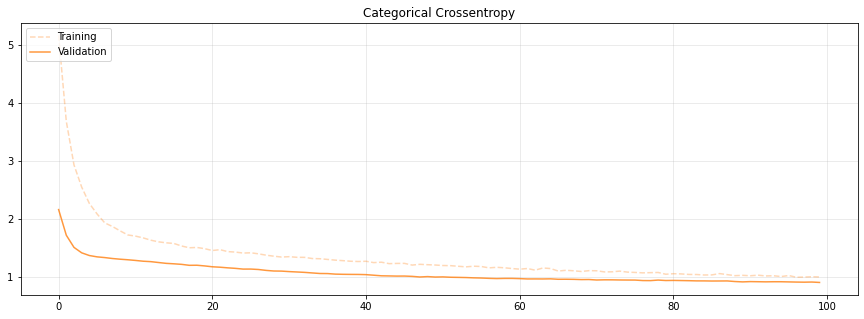

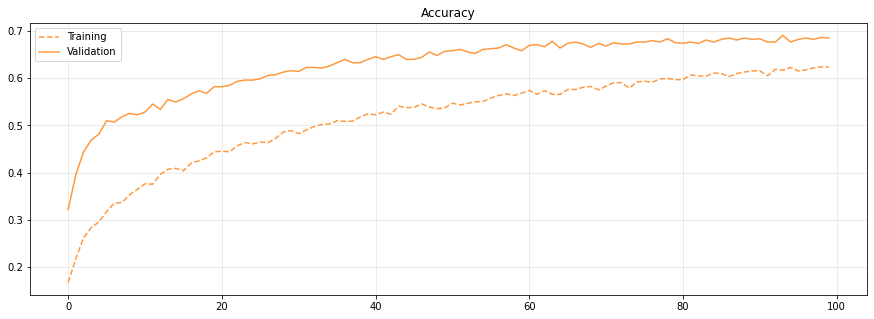

In [18]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

23/23 [==============================] - 1s 32ms/step - loss: 0.9100 - accuracy: 0.6850
{'loss': 0.9099544286727905, 'accuracy': 0.6850282549858093}
Accuracy: 0.685
Precision: 0.6681
Recall: 0.6368
F1: 0.642
F1 (per class):
[0.32727273 0.64454976 0.72803347 0.68686869 0.7254902  0.56410256
 0.75247525 0.70742358]
WORST CLASS: Species: 1


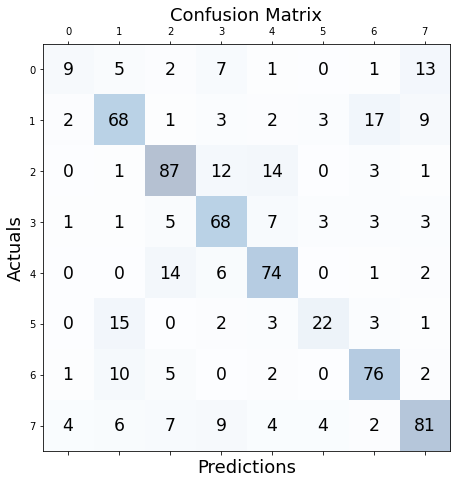

In [19]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Fine Tuning

**Now we want to do fine tuning, so we set the last 14 layers of VGG to trainable**

In [22]:
supernet.trainable = True

for i, layer in enumerate(model.get_layer('vgg19').layers[:-1]):
       layer.trainable=False
    
for i, layer in enumerate(model.get_layer('vgg19').layers[-14:-1]):
    layer.trainable = True

In [23]:
for i, layer in enumerate(model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [24]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 128, 128, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
Dense3 (Dense)               (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [25]:
callbacks = create_folders_and_callbacks(model_name='myModel')

history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks
).history

Epoch 1/100
200/200 [==============================] - 15s 71ms/step - loss: 1.7756 - accuracy: 0.3114 - val_loss: 1.2905 - val_accuracy: 0.5282
Epoch 2/100
200/200 [==============================] - 14s 70ms/step - loss: 1.4210 - accuracy: 0.4551 - val_loss: 1.0796 - val_accuracy: 0.5946
Epoch 3/100
200/200 [==============================] - 14s 69ms/step - loss: 1.2344 - accuracy: 0.5310 - val_loss: 0.9172 - val_accuracy: 0.6766
Epoch 4/100
200/200 [==============================] - 14s 68ms/step - loss: 1.0903 - accuracy: 0.5937 - val_loss: 0.9215 - val_accuracy: 0.6299
Epoch 5/100
200/200 [==============================] - 14s 69ms/step - loss: 0.9383 - accuracy: 0.6524 - val_loss: 0.9610 - val_accuracy: 0.6780
Epoch 6/100
200/200 [==============================] - 14s 68ms/step - loss: 0.8860 - accuracy: 0.6693 - val_loss: 0.7172 - val_accuracy: 0.7359
Epoch 7/100
200/200 [==============================] - 14s 68ms/step - loss: 0.7311 - accuracy: 0.7304 - val_loss: 0.6026 - val_ac

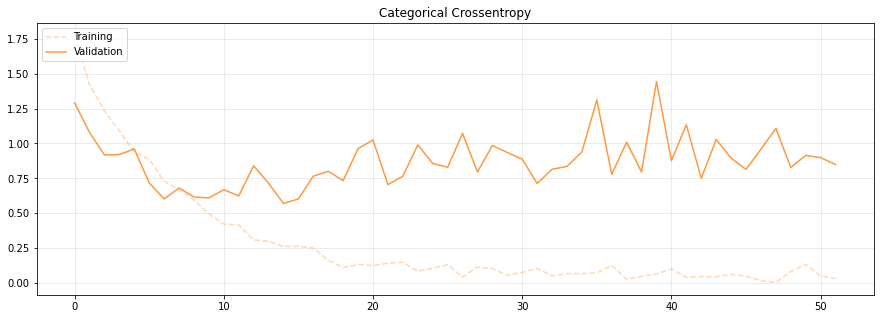

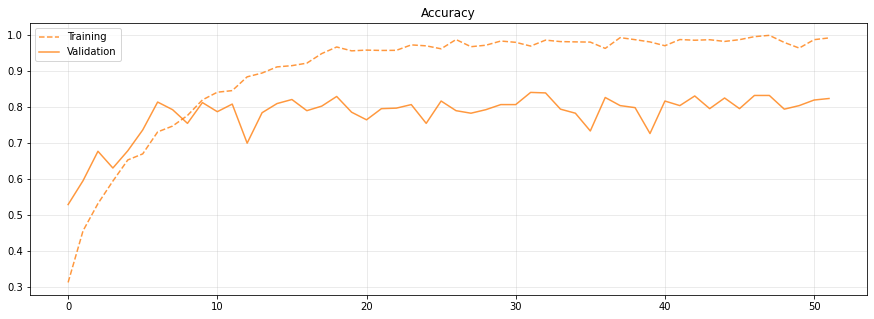

In [26]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

23/23 [==============================] - 1s 37ms/step - loss: 0.7128 - accuracy: 0.8404
{'loss': 0.7128235697746277, 'accuracy': 0.840395450592041}
Accuracy: 0.8404
Precision: 0.8267
Recall: 0.8093
F1: 0.8163
F1 (per class):
[0.52777778 0.83902439 0.88510638 0.86631016 0.82722513 0.85714286
 0.89690722 0.83064516]
WORST CLASS: Species: 1


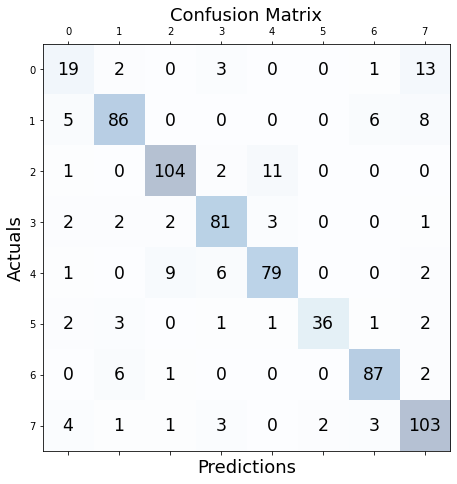

In [27]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [28]:
model.save("models/model_vgg19_84")

In [29]:
import shutil
shutil.make_archive("model_vgg_84", 'zip', "./models/model_vgg19_84")

'/kaggle/working/model_vgg_84.zip'